In [24]:
% Install package "image" if isn't available
%pkg install -forge image

In [25]:
% First, crear workspace
clear all;
% Load the image package
pkg load image
% First, add to path the iso2mesh package
addpath('iso2mesh/')
which vol2mesh

'vol2mesh' is a function from the file /home/jovyan/work/iso2mesh/vol2mesh.m


In [26]:
% Obtain binarized images from the subdirectory
imagedir = dir('sc04Images/*.bmp');
nfiles = size(imagedir)(1);
currentfile = imagedir(700).name;

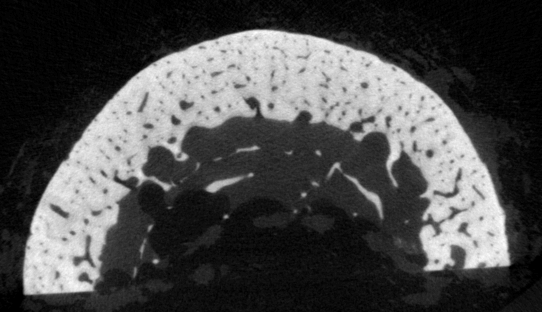

In [27]:
% Show full image of input
% The image are in [0, 255] grayscale
currentfull = imread(strcat('sc04Images/',currentfile));
imshow(currentfull)

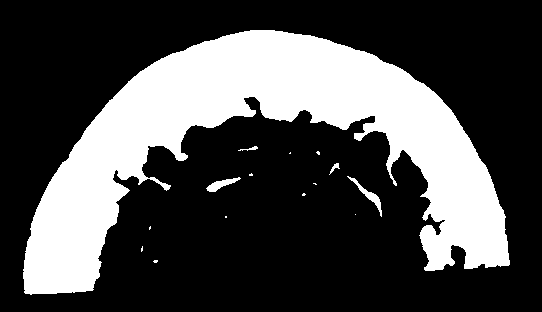

In [28]:
% Check different levels to extract main features
% The (0,1) --> (black, white) pixels
bone_section = 120*imfill(logical(currentfull >= 110), 'holes'); % 150
imshow(bone_section)

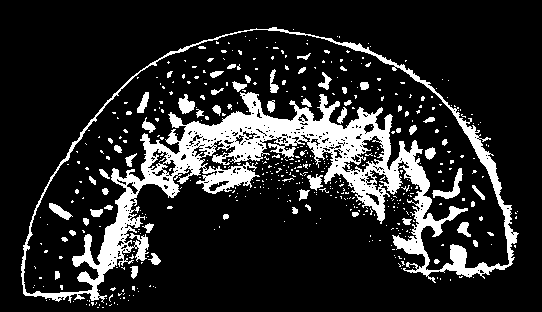

In [29]:
% Obtain the porous section of the currentimage variable
porous_part = logical(currentfull < 150); % 150
neglected_part = logical(currentfull >= 40); % 80
porous_section = 100*(porous_part & neglected_part);
imshow(porous_section)

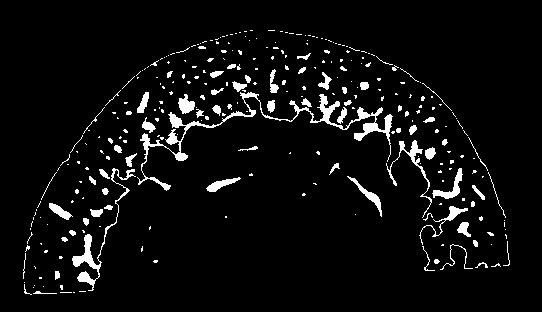

In [30]:
% Obtain porosity on the interior
porous_interior = logical(bone_section+porous_section > 130);
porous_section = imfill(porous_interior, 'holes');
imshow(porous_section)

   312   542


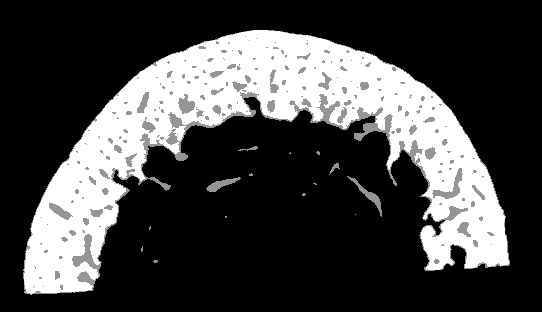

In [31]:
% Obtain image with bone matrix and interior porosities
disp(size(bone_section))
imshow(bone_section - 50*porous_section)

In [32]:
whos

Variables in the current scope:

   Attr Name                 Size                     Bytes  Class
   ==== ====                 ====                     =====  ===== 
        ans                  1x1                          8  double
        bone_section       312x542                  1352832  double
        currentfile          1x20                        20  char
        currentfull        312x542                   169104  uint8
        imagedir          1500x1                     258000  struct
        neglected_part     312x542                   169104  logical
        nfiles               1x1                          8  double
        porous_interior    312x542                   169104  logical
        porous_part        312x542                   169104  logical
        porous_section     312x542                   169104  logical

Total is 1016146 elements using 2456388 bytes



In [33]:
% Define tensor array to store image
start = 250; % the 50 first slices dont capture the full curvature!
nfiles = 1250; % Number of files to use, max number working > 1000
I_bone = zeros(312, 542, nfiles-start, 'uint8');
I_porous = zeros(312, 542, nfiles-start, 'uint8');
% Iterate over the stack of images
for i = 1:nfiles-start
    % Read each element of the directory
    currentfile = imagedir(i+start).name;
    %currentfile = imagedir(2*i+start).name;
    % Obtain the gray-scale [0, 255] image
    currentfull = imread(strcat('sc04Images/',currentfile));
    % Obtain bone section filled --> values > 110 on grayscale
    bone_section = imfill(logical(currentfull >= 110), 'holes'); % 150
    % Set each layer of the tensor array
    I_bone(:, :, i) = bone_section;
    
    % Obtain all porosities of the gray scale filled
    % with values  in [20, 150] grayscale level
    porous_part = logical(currentfull < 150); % 150
    neglected_part = logical(currentfull >= 40); % 80
    porous_section = porous_part & neglected_part;
    % Obtain porosity on the interior
    % 120*bon_sec + 100*por_sec > 150
    porous_interior = logical(120*bone_section+100*porous_section > 130);
    porous_section = imfill(porous_interior, 'holes');
    % Set each layer of the tensor array
    I_porous(:, :, i) = porous_section;
end   

### Case of mesh filled without holes

In [ ]:
% Obtain the 3d islands containing connected components
islands = bwconncomp(I_porous);
connnect = islands.Connectivity;
imgsize = islands.ImageSize;
numobj = islands.NumObjects;
pixellist = islands.PixelIdxList;

In [ ]:
% Define array containing the interested porosities
I_ids = zeros(size(I_porous), 'uint8');
% Generate different isovalues associated to each connected component
inputsize = size(I_porous);
mincc = 1000; % Define minimum size of connected commponent to consider.
points = {};
id = 1; % Identifier of id's
for cc = 1:int8(numobj)
    % In this case, only the bigger cc (connected component)
    if size(pixellist{cc}, 1) > mincc
        % Convert linear index to 2d index
        % (I, J, K) denotes the arrays of (i,j, k) components resp.
        [I,J,K] = ind2sub(inputsize, pixellist{cc});
        % Save coordinates to structure
        points(id, 1) = I;
        points(id, 2) = J;
        points(id, 3) = K;
        %for i = 1:size(pixellist{cc}, 1)
        %    I_ids(I(i), J(i), K(i)) = id;
        %end
        % Update id
        id += 1;
    endif
end

In [ ]:
% Define the multi-lable bone-porosity material
% being: 0 --> empty, 1 --> matrix, 2 --> porosity
id
imshow(I_bone(:,:, 240));
axis()

In [ ]:
% Generate mesh using iso2mesh function vol2mesh (using elements C3D4)
% First, define some parameters 
% by default, vol2mesh uses 'cgalsurf' method, which requires the following
optval = 20; % Max radius of Delaunay sphere
% 'cgalsurf' defines intersecting facets when using different radbounds!
% 'cgalmesh' seems to work better than cgalsurf!
maxvol = 200; % '1=50:2=10', maxvol specified for each subregion (levelset)
% Second, generate the mesh
[nodefill, elemfill, facefill]=vol2mesh(I_bone, 
                            1:size(I_bone,1),
                            1:size(I_bone,2),
                            1:size(I_bone,3),
                            optval, maxvol, 1, 'cgalmesh');

In [ ]:
disp('Head of nodes')
disp(nodefill(1:10, :, : ,:))
disp('Size of node array')
disp(size(nodefill))
%disp(node(1:10, [2 1 3]))
disp('Head of elems')
disp(elemfill(1:10, :, :, : ,:))
disp('Size of elem array')
disp(size(elemfill))

disp('Head of faces')
disp(facefill(1:10, :, :, : ,:))
disp('Size of faces array')
disp(size(facefill))

In [ ]:
% Quality check of mesh
quality = meshquality(nodefill(:,1:3),elemfill(:,1:4));
figure()
hist(quality,20)
meshname = 'Cortical Bone';
title(strcat('Histogram', meshname));

In [ ]:
% Save file to abaqus format --> then to xml file using "dolfin-convert"
%saveabaqus(node, face, elem, 'Cortical3dMesh.inp')
% Save mesh files for processing on fenics notebook
save -mat7-binary 'Cortical3dsc04Mesh1000SFill-CGALMeshOPT20Det.mat' nodefill elemfill facefill points

### Case of bone matrix and porosities

In [34]:
% Obtain the 3d islands containing connected components
islands = bwconncomp(I_porous);
connnect = islands.Connectivity;
imgsize = islands.ImageSize;
numobj = islands.NumObjects;
pixellist = islands.PixelIdxList;

In [36]:
% Define array containing the interested porosities
I_ids = zeros(size(I_porous), 'uint8');
% Generate different isovalues associated to each connected component
inputsize = size(I_porous);
mincc = 10000; % Define minimum size of connected commponent to consider.
id = 1; % Identifier of id's
for cc = 1:int8(numobj)
    % In this case, only the bigger cc (connected component)
    if size(pixellist{cc}, 1) > mincc
        % Convert linear index to 2d index
        % (I, J, K) denotes the arrays of (i,j, k) components resp.
        [I,J,K] = ind2sub(inputsize, pixellist{cc});
        for i = 1:size(pixellist{cc}, 1)
            I_ids(I(i), J(i), K(i)) = id;
        end
        % Update id
        id += 1;
    endif
end
% Define the taged bone structure with porosities
I_tagged = I_bone + I_ids;
id

id =  2


id_test =  2


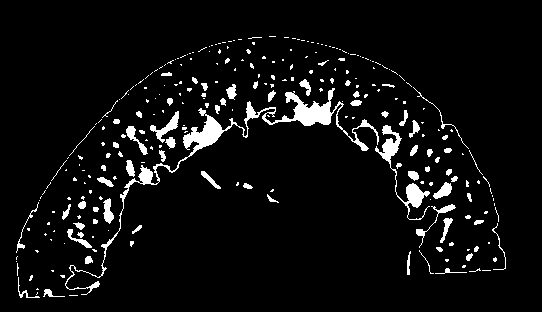

In [42]:
% Display porosity with id
id_test = 2
imshow(I_tagged(:, :, 200) == id_test)

ans =

     0.50000   542.50000     0.50000   312.50000



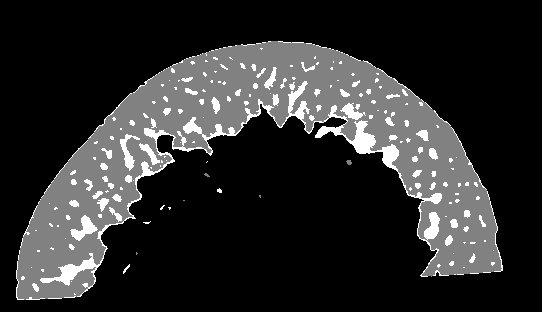

In [43]:
% Define the multi-lable bone-porosity material
% being: 0 --> empty, 1 --> matrix, 2,3,... --> porosity
%I_full = I_bone + I_porous;
imshow(I_tagged(:,:, 50));
axis()

In [44]:
% Generate mesh using iso2mesh function vol2mesh (using elements C3D4)
% by default, vol2mesh uses 'cgalsurf' method
% First, Iterate over the labels
optpor.type = '()';
optpor(1).radbound = 5000; % 50, Max radius at levelset tagged with 1 (matrix)
isovals(1) = 1;
% Max radius for the rest of tags (porosity)
for i = 2:id
    optpor(i).radbound = 5000; % 10
    isovals(i) = i;
end
maxvol = 5000; % 200, maxvol specified for each subregion (levelset)
% Second, generate the mesh
% method: cgalmesh seems to be working!
[node, elem, face]=vol2mesh(I_tagged, 
                            1:size(I_tagged,1), 1:size(I_tagged,2), 1:size(I_tagged,3), 
                            optpor, maxvol, 1,'cgalmesh', isovals);
                            
% Other type of repairs not being used!.     
%[node, elem]=meshcheckrepair(node, elem, 'dup')
%[node, elem]=meshcheckrepair(node, elem, 'meshfix')

    vol2mesh at line 46 column 3
creating surface and tetrahedral mesh from a multi-domain volume ...
    fallbackexeext at line 23 column 1
    cgalv2m at line 50 column 8
    vol2mesh at line 54 column 18
    fallbackexeext at line 26 column 1
    cgalv2m at line 50 column 8
    vol2mesh at line 54 column 18
    mwpath at line 54 column 21
    cgalv2m at line 68 column 1
    vol2mesh at line 54 column 18
    mwpath at line 54 column 21
    cgalv2m at line 69 column 1
    vol2mesh at line 54 column 18
    mwpath at line 54 column 21
    cgalv2m at line 82 column 4
    vol2mesh at line 54 column 18
    mwpath at line 54 column 21
    cgalv2m at line 82 column 4
    vol2mesh at line 54 column 18
Volume/Surface Mesh Generation Utility (Based on CGAL 3.8)
(modified for iso2mesh by Qianqian Fang and Peter Varga)
http://iso2mesh.sf.net

RNG seed=1648335518
Mesh sizes are (label=size) (1=5000) 
Killed
    mwpath at line 54 column 21
    cgalv2m at line 86 column 1
    vol2mesh at line 54 col

In [20]:
disp('Head of nodes')
disp(node(1:10, :, : ,:))
disp('Size of node array')
disp(size(node))
%disp(node(1:10, [2 1 3]))
disp('Head of elems')
disp(elem(1:10, :, :, : ,:))
disp('Size of elem array')
disp(size(elem))

disp('Head of faces')
disp(face(1:10, :, :, : ,:))
disp('Size of faces array')
disp(size(face))

Head of nodes
   191.28747    46.08888   440.60838     1.50000
   191.38126    44.96924   440.35553     2.50000
   192.00794    45.58077   439.69727     0.50000
   191.38294    45.08359   441.50150     0.50000
   191.02829    46.08053   439.28179     1.50000
   190.15079    45.14595   440.68597     0.50000
   192.47485    44.99985   440.71531     0.50000
   191.49277    45.98165   442.50090     1.50000
   192.42170    45.02297   441.73666     0.50000
   191.43807    44.90320   439.05218     2.50000
Size of node array
   1414218         4
Head of elems
    1    2    3    5    2
    1    2    3    7    2
    1    2    4    6    2
    1    2    4    7    2
    1    2    5    6    2
    1    3    5   61    1
    1    3    7   20    1
    1    3   20   61    1
    1    4    6   12    2
    1    4    7    9    1
Size of elem array
   7138920         5
Head of faces
    1    3    5    1
    1    3    5    2
    1    3    7    1
    1    3    7    2
    1    4    7    1
    1    4    7    2
  

In [21]:
% Porosity level after applied the grayscale filtering!
disp("Porosity Level after grayscale filtering")
disp(sum(sum(elem(:, 5) > 1))/sum(sum(elem(:, 5) == 1)))

Porosity Level after grayscale filtering
 0.90968


In [22]:
% Quality check of mesh
#quality = meshquality(node(:,1:3),elem(:,1:4));
#figure()
#hist(quality,20)
#meshname = 'Cortical Bone';
#title(strcat('Histogram', meshname));

In [23]:
% Save file to abaqus format --> then to xml file using "dolfin-convert"
%saveabaqus(node, face, elem, 'Cortical3dMesh.inp')
% Save mesh files for processing on fenics notebook
save -mat7-binary 'Cortical3dsc04Mesh500S-CGALMeshOPT20.mat' node elem face